In [17]:
import cv2 as cv
import numpy as np
import mediapipe as mp
import os
from matplotlib import pyplot as plt
import math
import time

DATA_PATH_2 = os.path.join('D:\\abc','MP_Data_2_Test') 
actions = np.array(['normal','drowsy'])
no_sequences = 30
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], [] 

arr_2 =  [[0 for j in range(no_sequences)] for i in range(len(actions))]
for idx, lm in enumerate(actions):
    for sequence in range(no_sequences+1,34) :  # 5번 반복(영상 수)
        res_2 = np.load(os.path.join(DATA_PATH_2, lm, "{}.npy".format(str(sequence+1))))
        arr_2[idx][sequence] = res_2
        
arr_2 = np.array(arr_2)

FOR_3D = [386, 374,263, 362,159, 145,133, 33]
FACE=list(range(468))

LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT = [386, 374,263, 362]
RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT = [159, 145,133, 33]


LEFT_EYE_TOP_BOTTOM = [386, 374]
LEFT_EYE_LEFT_RIGHT = [263, 362]

RIGHT_EYE_TOP_BOTTOM = [159, 145]
RIGHT_EYE_LEFT_RIGHT = [133, 33]

def draw_landmark(height, width, outputs, land_mark, color):
    for face in land_mark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        point_scale = ((int)(point.x * width), (int)(point.y * height))
        cv.circle(image, point_scale, 2, color, 1)
        
def cal_distance(height, width, camera_point1, camera_point2):
    point1 = int(camera_point1.x * width), int(camera_point1.y * height)
    point2 = int(camera_point2.x * width), int(camera_point2.y * height)
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
    return distance

def get_aspect_ratio(height, width, outputs, top_bottom, left_right, secant):
    landmark = outputs.multi_face_landmarks[0]
            
    top = landmark.landmark[top_bottom[0]]
    bottom = landmark.landmark[top_bottom[1]]
    top_bottom_dis = cal_distance(height, width, top, bottom) * secant
    
    left = landmark.landmark[left_right[0]]
    right = landmark.landmark[left_right[1]]
    left_right_dis = cal_distance(height, width, left, right)
    
    aspect_ratio = top_bottom_dis / left_right_dis
    return aspect_ratio

def cal_ratio(height,width, outputs, left, right, secant):
    landmark = outputs.multi_face_landmarks[0]
    top1 = landmark.landmark[left[0]]
    bottom1 = landmark.landmark[left[1]]
    top_bottom_dis1 = cal_distance(height,width, top1, bottom1)

    top2 = landmark.landmark[right[0]]
    bottom2 = landmark.landmark[right[1]]
    top_bottom_dis2 = cal_distance(height,width, top2, bottom2)

    lwide1 = landmark.landmark[left[2]]
    rwide1 = landmark.landmark[left[3]]
    lwide_rwide_dis1 = cal_distance(height,width,lwide1, rwide1)

    lwide2 = landmark.landmark[right[2]]
    rwide2 = landmark.landmark[right[3]]
    lwide_rwide_dis2 = cal_distance(height,width,lwide2, rwide2)

    sum_wide = 0
    sum_height = 0

    if lwide_rwide_dis1!=0 and lwide_rwide_dis2 != 0: # 가로 길이 보정
        if lwide_rwide_dis1/lwide_rwide_dis2 > 1.1 or lwide_rwide_dis1 /lwide_rwide_dis2 < 0.9:
            if lwide_rwide_dis1 > lwide_rwide_dis2:
                sum_wide = round(lwide_rwide_dis1/2)*2
            else:
                sum_wide = round(lwide_rwide_dis2/2)*2
        else:
            sum_wide = (round(lwide_rwide_dis1/3)*3+round(lwide_rwide_dis2/3)*3)/2
    
    if top_bottom_dis1 !=0 and top_bottom_dis2 != 0: # 세로 길이 보정
        if top_bottom_dis1/top_bottom_dis2 > 1.1 or top_bottom_dis1/top_bottom_dis2 < 0.9:
            if top_bottom_dis1 > top_bottom_dis2:
                sum_height = round(top_bottom_dis1/2)*2
            else:
                sum_height = round(top_bottom_dis2/2)*2
        else:
            sum_height =(round(top_bottom_dis1/2)*2+round(top_bottom_dis2/2)*2)/2
    
    secant_u = math.ceil(secant*100)/100
    secant_d = math.floor(secant*100)/100
    aspect_ratio = round((round((sum_height*secant_u*secant_u*secant_u)/(sum_wide*secant_d*secant_d)/2, 3)
                        * 2 + round((sum_height*secant_u*secant_u*secant_u)/(sum_wide*secant_d*secant_d)/5, 2)*5) /2, 4)

    # aspect_ratio = round(sum_height/sum_wide/2*secant,2)*2
    
    cv.putText(image, "ratio: " + str(aspect_ratio), (100, 90), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    return aspect_ratio

def get_3D(height, width, outputs, landmark):
    face_3d = []
    face_2d = []

    for face in landmark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        x, y = int(point.x * width), int(point.y * height)
        face_2d.append([x, y])
        face_3d.append([x, y, point.z])       

    face_2d = np.array(face_2d, dtype=np.float64)
    face_3d = np.array(face_3d, dtype=np.float64)
    focal_length = width
    cam_matrix = np.array([ [focal_length, 0, height / 2],
                            [0, focal_length, width / 2],
                            [0, 0, 1]])
    dist_matrix = np.zeros((4, 1), dtype=np.float64)
    success, rot_vec, trans_vec = cv.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)
    rmat, jac = cv.Rodrigues(rot_vec)
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv.RQDecomp3x3(rmat)
    
    x = angles[0] * 360 * math.pi * 0.75+7

    x = np.round(x,1)
    if x > 40 :
        x = 40
    elif x <-40:
        x = -40  
    cv.putText(image, "x: " + str(x), (100, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    return x
##    
face_mesh = mp.solutions.face_mesh
draw_utils = mp.solutions.drawing_utils
face_model = face_mesh.FaceMesh(max_num_faces= 1,
                                refine_landmarks=True,
                                min_detection_confidence=0.5,
                                min_tracking_confidence=0.5)

total = []
for jj in range(2,3):
    for i in range(31,34):
        a =str(i)+"_"+str(jj)+".mp4"
        ## 영상 입력
        name = a
        cap = cv.VideoCapture(name)

        ## 영상 이름 인식
        if(name[1]!='_'):
            im = name[0]+name[1]
            print(im)    
            sequence = int(im) # '1_2.mp4' 에서 '1' -> 비디오 순서
            if int(name[3]) - 1 == 0:
                action = actions[0] # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
            else:
                action = actions[1]
        else:
            sequence = int(name[0]) # '1_2.mp4' 에서 '1' -> 비디오 순서
            if int(name[2]) - 1 == 0:
                action = actions[0] # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
            else:
                action = actions[1]
                
        set_ratio = arr_2[0][i-1]
        print(arr_2[0][i-1], arr_2[1][i-1])
        ratio_threshold =0.87231284*set_ratio -0.0018257729
        print(ratio_threshold)
        count = 0
        ratio_mean = []
        while cap.isOpened():
            result, image = cap.read()
            if not result:
                print("Ignoring empty camera frame.")
                break
            else:
                height, width =image.shape[:2]
                image.flags.writeable = False
                image = cv.cvtColor(cv.flip(image, 1), cv.COLOR_BGR2RGB)
                outputs = face_model.process(image)
                image.flags.writeable = True
                image = cv.cvtColor(image, cv.COLOR_RGB2BGR)

                if outputs.multi_face_landmarks:
                    count = count + 1
                    ##
                    draw_landmark(height, width,outputs, FOR_3D, (0,255,0))
                    draw_landmark(height, width,outputs, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))
                    draw_landmark(height, width,outputs, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))
        
                    # secant 계산
                    get_face_angle = get_3D(height, width,outputs,FACE)
                    th1 = math.radians(get_face_angle)
                    secant1 = 1.0/math.cos(th1)
                    # secant1 = 1

                    ratio =  cal_ratio(height, width,outputs, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT,secant1)
                    if ratio < ratio_threshold:
                        ratio_mean.append(ratio)

                cv.imshow("FACE MESH", image)
                key = cv.waitKey(2)
                if key==ord('s') or key ==ord('S'): # s를 누르면 초기 눈 비율 설정
                    print("현재 눈 비율(각도를 고려한)",ratio)
                    set_ratio = ratio # 초기 눈 비율 설정
                    ratio_threshold = 1.077*set_ratio - 0.071
                    print(ratio_threshold)
                elif key==ord('q') or key ==ord('Q'): # q를 누르면 종료
                    break

        cap.release()
        cv.destroyAllWindows()
        total.append(sum(ratio_mean)/count)
        print(sum(ratio_mean)/count)
print(sum(total)/len(total))
    

IndexError: list assignment index out of range

In [18]:
import cv2 as cv
import numpy as np
import mediapipe as mp
import os
from matplotlib import pyplot as plt
import math
import time
# MP_Data_2_no_angle_noblink
DATA_PATH_2 = os.path.join('D:\\abc','MP_Data_2_Test') 
actions = np.array(['normal','drowsy'])
no_sequences = 30
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], [] 

arr_2 =  [[0 for j in range(no_sequences)] for i in range(len(actions))]
for idx, lm in enumerate(actions):
    for sequence in range(no_sequences+1,34) :  # 5번 반복(영상 수)
        res_2 = np.load(os.path.join(DATA_PATH_2, lm, "{}.npy".format(str(sequence+1))))
        arr_2[idx][sequence] = res_2
        
arr_2 = np.array(arr_2)

FOR_3D = [386, 374,263, 362,159, 145,133, 33]
FACE=list(range(468))

LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT = [386, 374,263, 362]
RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT = [159, 145,133, 33]


LEFT_EYE_TOP_BOTTOM = [386, 374]
LEFT_EYE_LEFT_RIGHT = [263, 362]

RIGHT_EYE_TOP_BOTTOM = [159, 145]
RIGHT_EYE_LEFT_RIGHT = [133, 33]

def draw_landmark(height, width, outputs, land_mark, color):
    for face in land_mark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        point_scale = ((int)(point.x * width), (int)(point.y * height))
        cv.circle(image, point_scale, 2, color, 1)
        
def cal_distance(height, width, camera_point1, camera_point2):
    point1 = int(camera_point1.x * width), int(camera_point1.y * height)
    point2 = int(camera_point2.x * width), int(camera_point2.y * height)
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
    return distance

def get_aspect_ratio(height, width, outputs, top_bottom, left_right, secant):
    landmark = outputs.multi_face_landmarks[0]
            
    top = landmark.landmark[top_bottom[0]]
    bottom = landmark.landmark[top_bottom[1]]
    top_bottom_dis = cal_distance(height, width, top, bottom) * secant
    
    left = landmark.landmark[left_right[0]]
    right = landmark.landmark[left_right[1]]
    left_right_dis = cal_distance(height, width, left, right)
    
    aspect_ratio = top_bottom_dis / left_right_dis
    return aspect_ratio

def cal_ratio(height,width, outputs, left, right, secant):
    landmark = outputs.multi_face_landmarks[0]
    top1 = landmark.landmark[left[0]]
    bottom1 = landmark.landmark[left[1]]
    top_bottom_dis1 = cal_distance(height,width, top1, bottom1)

    top2 = landmark.landmark[right[0]]
    bottom2 = landmark.landmark[right[1]]
    top_bottom_dis2 = cal_distance(height,width, top2, bottom2)

    lwide1 = landmark.landmark[left[2]]
    rwide1 = landmark.landmark[left[3]]
    lwide_rwide_dis1 = cal_distance(height,width,lwide1, rwide1)

    lwide2 = landmark.landmark[right[2]]
    rwide2 = landmark.landmark[right[3]]
    lwide_rwide_dis2 = cal_distance(height,width,lwide2, rwide2)

    sum_wide = 0
    sum_height = 0

    if lwide_rwide_dis1!=0 and lwide_rwide_dis2 != 0: # 가로 길이 보정
        if lwide_rwide_dis1/lwide_rwide_dis2 > 1.1 or lwide_rwide_dis1 /lwide_rwide_dis2 < 0.9:
            if lwide_rwide_dis1 > lwide_rwide_dis2:
                sum_wide = round(lwide_rwide_dis1/2)*2
            else:
                sum_wide = round(lwide_rwide_dis2/2)*2
        else:
            sum_wide = (round(lwide_rwide_dis1/3)*3+round(lwide_rwide_dis2/3)*3)/2
    
    if top_bottom_dis1 !=0 and top_bottom_dis2 != 0: # 세로 길이 보정
        if top_bottom_dis1/top_bottom_dis2 > 1.1 or top_bottom_dis1/top_bottom_dis2 < 0.9:
            if top_bottom_dis1 > top_bottom_dis2:
                sum_height = round(top_bottom_dis1/2)*2
            else:
                sum_height = round(top_bottom_dis2/2)*2
        else:
            sum_height =(round(top_bottom_dis1/2)*2+round(top_bottom_dis2/2)*2)/2
    
    secant_u = math.ceil(secant*100)/100
    secant_d = math.floor(secant*100)/100
    aspect_ratio = round((round((sum_height*secant_u*secant_u*secant_u)/(sum_wide*secant_d*secant_d)/2, 3)
                        * 2 + round((sum_height*secant_u*secant_u*secant_u)/(sum_wide*secant_d*secant_d)/5, 2)*5) /2, 4)

    # aspect_ratio = round(sum_height/sum_wide/2*secant,2)*2
    
    cv.putText(image, "ratio: " + str(aspect_ratio), (100, 90), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    return aspect_ratio

def get_3D(height, width, outputs, landmark):
    face_3d = []
    face_2d = []

    for face in landmark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        x, y = int(point.x * width), int(point.y * height)
        face_2d.append([x, y])
        face_3d.append([x, y, point.z])       

    face_2d = np.array(face_2d, dtype=np.float64)
    face_3d = np.array(face_3d, dtype=np.float64)
    focal_length = width
    cam_matrix = np.array([ [focal_length, 0, height / 2],
                            [0, focal_length, width / 2],
                            [0, 0, 1]])
    dist_matrix = np.zeros((4, 1), dtype=np.float64)
    success, rot_vec, trans_vec = cv.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)
  
    rmat, jac = cv.Rodrigues(rot_vec)
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv.RQDecomp3x3(rmat)
    
    x = angles[0] * 360 * math.pi * 0.75+7

    x = np.round(x,1)
    if x > 40 :
        x = 40
    elif x <-40:
        x = -40  
    cv.putText(image, "x: " + str(x), (100, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    return x
##    
face_mesh = mp.solutions.face_mesh
draw_utils = mp.solutions.drawing_utils
face_model = face_mesh.FaceMesh(max_num_faces= 1,
                                refine_landmarks=True,
                                min_detection_confidence=0.5,
                                min_tracking_confidence=0.5)

total = []
for jj in range(2,3):
    for i in range(31,34):
        a =str(i)+"_"+str(jj)+".mp4"
        ## 영상 입력
        name = a
        cap = cv.VideoCapture(name)

        ## 영상 이름 인식
        if(name[1]!='_'):
            im = name[0]+name[1]
            print(im)    
            sequence = int(im) # '1_2.mp4' 에서 '1' -> 비디오 순서
            if int(name[3]) - 1 == 0:
                action = actions[0] # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
            else:
                action = actions[1]
        else:
            sequence = int(name[0]) # '1_2.mp4' 에서 '1' -> 비디오 순서
            if int(name[2]) - 1 == 0:
                action = actions[0] # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
            else:
                action = actions[1]
                
        set_ratio = arr_2[0][i-1]
        # print(arr_2[0][i-1], arr_2[1][i-1])
        # ratio_threshold =0.87231284*set_ratio -0.0018257729
        # print(ratio_threshold)
        count = 0
        ratio_mean = []
        ratioh = []
        
        while cap.isOpened():
            result, image = cap.read()
            if not result:
                print("Ignoring empty camera frame.")
                break
            else:
                height, width =image.shape[:2]
                image.flags.writeable = False
                image = cv.cvtColor(cv.flip(image, 1), cv.COLOR_BGR2RGB)
                outputs = face_model.process(image)
                image.flags.writeable = True
                image = cv.cvtColor(image, cv.COLOR_RGB2BGR)

                if outputs.multi_face_landmarks:
                    count = count + 1
                    ##
                    draw_landmark(height, width,outputs, FOR_3D, (0,255,0))
                    draw_landmark(height, width,outputs, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))
                    draw_landmark(height, width,outputs, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))
        
                    # secant 계산
                    get_face_angle = get_3D(height, width,outputs,FACE)
                    th1 = math.radians(get_face_angle)
                    secant1 = 1.0/math.cos(th1)
                    # secant1 = 1

                    ratio =  cal_ratio(height, width,outputs, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT,secant1)
                    ratioh.append(ratio)
                
                    # if ratio < ratio_threshold:
                    #     ratio_mean.append(ratio)

                cv.imshow("FACE MESH", image)
                key = cv.waitKey(2)
                if key==ord('s') or key ==ord('S'): # s를 누르면 초기 눈 비율 설정
                    print("현재 눈 비율(각도를 고려한)",ratio)
                    set_ratio = ratio # 초기 눈 비율 설정
                    ratio_threshold = 1.077*set_ratio - 0.071
                    print(ratio_threshold)
                elif key==ord('q') or key ==ord('Q'): # q를 누르면 종료
                    break

        cap.release()
        cv.destroyAllWindows()
        ratio_threshold = (set_ratio - min(ratioh))*0.8 + min(ratioh)
        print("min(ratioh)",min(ratioh))
        ratioh = np.array(ratioh)
        ratioh = (ratioh <= ratio_threshold)
        ratioh = ratioh.tolist()
        total.append(ratioh.count(True)/len(ratioh))
        print("accuracy",ratioh.count(True)/len(ratioh))
        
print(sum(total)/len(total))


#         total.append(sum(ratio_mean)/count)
#         print(sum(ratio_mean)/count)
# print(sum(total)/len(total))
    

IndexError: list assignment index out of range

In [21]:
# 1 : TEST

import cv2 as cv
import numpy as np
import mediapipe as mp
import math
import time
import os

DATA_PATH = os.path.join('D:\\abc','MP_Data_2_different_noblink_6') 
actions = np.array(['normal','drowsy'])
sequence_length = 30
label_map = {label:num for num, label in enumerate(actions)}
sequences = []

for action in actions:
    window = []
    for frame_num in range(sequence_length):
        res = np.load(os.path.join(DATA_PATH, action, "{}.npy".format(frame_num+1)))
        window.append(res)
    sequences.append(window)

sequences = np.array(sequences)


def draw_landmarks(image, outputs, land_mark, color):
    height, width =image.shape[:2]
    if type(land_mark) != int:
        for face in land_mark:
            point = outputs.multi_face_landmarks[0].landmark[face]
            
            point_scale = ((int)(point.x * width), (int)(point.y * height))
            
            cv.circle(image, point_scale, 2, color, 1)
    else:
        point = outputs.multi_face_landmarks[0].landmark[land_mark]     
        point_scale = ((int)(point.x * width), (int)(point.y * height))
        cv.circle(image, point_scale, 2, color, 1) 

def euclidean_distance(image, top, bottom):
    height, width = image.shape[0:2]
            
    point1 = int(top.x * width), int(top.y * height)
    point2 = int(bottom.x * width), int(bottom.y * height)
    
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
    return distance

def x_distance(image, outputs, top, bottom):
    height, width = image.shape[0:2]
    landmark = outputs.multi_face_landmarks[0]
            
    top_1 = landmark.landmark[top]
    bottom_1 = landmark.landmark[bottom]
            
    point1 = int(top_1.x * width), int(top_1.y * height)
    point2 = int(bottom_1.x * width), int(bottom_1.y * height)
    
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
    return distance

def get_aspect_ratio(image, outputs, top_bottom, left_right, secant):
    landmark = outputs.multi_face_landmarks[0]

    left = landmark.landmark[left_right[0]]
    right = landmark.landmark[left_right[1]]
    left_right_dis = euclidean_distance(image, left, right) 

    top = landmark.landmark[top_bottom[0]]
    bottom = landmark.landmark[top_bottom[1]]
    
    # 각도x
    top_bottom_dis1 = euclidean_distance(image, top, bottom)
    # 각도o
    top_bottom_dis2 = euclidean_distance(image, top, bottom) * secant
    # 각도x
    aspect_ratio1 = top_bottom_dis1 / left_right_dis
    # 각도o
    aspect_ratio2 = top_bottom_dis2 / left_right_dis
    
    return aspect_ratio1, aspect_ratio2
    
def get_3D(image, outputs, landmark):
    height, width =image.shape[:2]
    face_3d = []
    face_2d = []

    for face in landmark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        x, y = int(point.x * width), int(point.y * height)
        face_2d.append([x, y])
        face_3d.append([x, y, point.z])       

    face_2d = np.array(face_2d, dtype=np.float64)
    face_3d = np.array(face_3d, dtype=np.float64)
    focal_length = width
    cam_matrix = np.array([ [focal_length, 0, height / 2],
                            [0, focal_length, width / 2],
                            [0, 0, 1]])
    dist_matrix = np.zeros((4, 1), dtype=np.float64)
    success, rot_vec, trans_vec = cv.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)
  
    rmat, jac = cv.Rodrigues(rot_vec)
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv.RQDecomp3x3(rmat)
    
    x = angles[0] * 360 * math.pi * 0.7+7
    
    x = np.round(x,1)
    # cv.putText(image, "pitch: " + str(x), (300, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    if x > 40 :
        x = 40
    elif x <-40:
        x = -40 
    return x

face_mesh = mp.solutions.face_mesh
draw_utils = mp.solutions.drawing_utils
landmark_style = draw_utils.DrawingSpec((0,255,0), thickness=1, circle_radius=1)
connection_style = draw_utils.DrawingSpec((0,0,255), thickness=1, circle_radius=1)

STATIC_IMAGE = False
MAX_NO_FACES = 2
DETECTION_CONFIDENCE = 0.5
TRACKING_CONFIDENCE = 0.5

COLOR_RED = (0,0,255)
COLOR_BLUE = (255,0,0)
COLOR_GREEN = (0,255,0)

RIGHT_EYE = [ 33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161 , 246 ]
LEFT_EYE = [ 362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385,384, 398 ]

LEFT_EYE_TOP_BOTTOM = [386, 374]
LEFT_EYE_LEFT_RIGHT = [263, 362]

RIGHT_EYE_TOP_BOTTOM = [159, 145]
RIGHT_EYE_LEFT_RIGHT = [133, 33]

FACE=list(range(468))

face_model = face_mesh.FaceMesh(static_image_mode=STATIC_IMAGE,
                                max_num_faces= MAX_NO_FACES,
                                min_detection_confidence=DETECTION_CONFIDENCE,
                                min_tracking_confidence=TRACKING_CONFIDENCE)

cap = cv.VideoCapture("16_1.mp4")

ratio_mean= []

fps2 = cap.get(cv.CAP_PROP_FPS)

basic1 = []
basic1_1 = []
basic1_1_1 = []
basic1_1_1_1 = []

eye_ratio1 = []
eye_ratio2 = []

x_length1 = []
x_length2 = []
get_ratio1 = []

y_length1 = []
y_length2 = []
get_ratio2 = []
get_ratio3 = []

check = []
eye_open_state = []
get_face_angle_variance = []
zer0 = []
zero_temp = 0
ratio_temp = 0
a = 0
bb = 0
cc = 0
frame_count = 0
dd = 0
ee = 0
thres = 0
rreal = 0
findzero = []
ff = 0
while cap.isOpened():
    result, image = cap.read()
    frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    if not result:
        print("Ignoring empty camera frame.")
        break
    else:
        image.flags.writeable = False
        image = cv.cvtColor(cv.flip(image, 1), cv.COLOR_BGR2RGB) 
        outputs = face_model.process(image)
        image.flags.writeable = True
        image = cv.cvtColor(image, cv.COLOR_RGB2BGR)

        if outputs.multi_face_landmarks:
            draw_landmarks(image, outputs, LEFT_EYE_TOP_BOTTOM, COLOR_RED)
            draw_landmarks(image, outputs, LEFT_EYE_LEFT_RIGHT, COLOR_RED)
            draw_landmarks(image, outputs, RIGHT_EYE_TOP_BOTTOM, COLOR_RED)
            draw_landmarks(image, outputs, RIGHT_EYE_LEFT_RIGHT, COLOR_RED)

            get_face_angle = get_3D(image,outputs,FACE)
            th1 = math.radians(get_face_angle)
            secant = 1.0/math.cos(th1)
            

####################################################################################################################
            ratio_left =  get_aspect_ratio(image, outputs, LEFT_EYE_TOP_BOTTOM, LEFT_EYE_LEFT_RIGHT,secant)
            ratio_right =  get_aspect_ratio(image, outputs, RIGHT_EYE_TOP_BOTTOM, RIGHT_EYE_LEFT_RIGHT,secant)
            
            # 각도x, 평균
            ratio1 = (ratio_left[0] + ratio_right[0])/2.0
            # 각도o, 평균
            ratio2 = (ratio_left[1] + ratio_right[1])/2.0

####################################################################################################################
            # 가로 길이 
            str_x = x_distance(image,outputs,LEFT_EYE_LEFT_RIGHT[0],LEFT_EYE_LEFT_RIGHT[1])
            str_xx =  x_distance(image,outputs,RIGHT_EYE_LEFT_RIGHT[0],RIGHT_EYE_LEFT_RIGHT[1])
            # 세로 길이 
            str_y = x_distance(image,outputs,LEFT_EYE_TOP_BOTTOM[0],LEFT_EYE_TOP_BOTTOM[1])
            str_yy = x_distance(image,outputs,RIGHT_EYE_TOP_BOTTOM[0],RIGHT_EYE_TOP_BOTTOM[1])

            # 가로, 세로 합
            str_xxx = (str_x + str_xx)
            str_yyy = (str_y + str_yy)
                
            # 각도x, 높이합
            mean = str_yyy / str_xxx
            if(len(zer0) < 1 and mean != 0):
                zer0.append(mean)
            if(len(zer0) == 1):
                a = zer0[0] 
                thres = (a + 0.2 )/2
            if mean <= thres and (get_face_angle >10 or get_face_angle <-10):
                dd = dd + 1
            elif mean <= thres and (get_face_angle <=10 and get_face_angle >=-10):
                ff = ff + 1

            zer0.append(mean)

            # 각도o, 높이합
            mean2 = str_yyy / str_xxx * secant
            
                
            # append
            # basic1.append([ratio1,get_face_angle]) # 각도x, 평균
            # x_length1.append([str_xxx/2, get_face_angle]) # 가로합
            # y_length1.append([str_yyy/2, get_face_angle]) # 세로합
            
#######################################################################################
            str_z = 0
            str_zz = 0

            if str_x!=0 and str_xx != 0: # 가로 길이 보정
                if str_x/str_xx > 1.1 or str_x /str_xx < 1/1.1:
                    if str_x > str_xx:
                        str_z = round(str_x/2)*2
                    else:
                        str_z = round(str_xx/2)*2
                else:
                    str_z = (round(str_x/2)*2+round(str_xx/2)*2)/2
           
            if str_y !=0 and str_yy != 0: # 세로 길이 보정
                if str_y/str_yy > 1.2 or str_y/str_yy < 1/1.2:
                    if str_y > str_yy:
                        str_zz = round(str_y/2,2)*2
                    else:
                        str_zz = round(str_yy/2,2)*2
                else:
                    str_zz =(round(str_y/2,2)*2+round(str_yy/2,2)*2)/2

            # 각도x, 보정 높이합
            different1 = (str_zz/str_z)
            secant_u = math.ceil(secant*100)/100
            secant_d = math.floor(secant*100)/100
            # 각도o, 보정 높이합
            # different2 =round( (round((str_zz*secant_u*secant_u)/(str_z*secant_d)/2,2)*2 + round((str_zz*secant_u*secant_u)/(str_z*secant_d)/5,2)*5 + round((str_zz*secant_u*secant_u)/(str_z*secant_d)/3,2)*3)/3,2)
            different2 = round((round((str_zz*secant_u*secant_u*secant_u)/(str_z*secant_d*secant_d)/2,3)*2+round((str_zz*secant_u*secant_u*secant_u)/(str_z*secant_d*secant_d)/5,2)*5)/2,4)
            # if different2 < 0.21:
            #     different2 = 0.01
            a = different2
            # if different2 == 0:
            #     different2 = 0.001

            check.append(different2)
            get_face_angle_variance.append(get_face_angle)
            variance = 0
            # get_ratio2.append([different2, get_face_angle]) # 보정 각도 세로합

            if check[-1] < 0.25:
                ee = ee+1
                # zer0.append(check[-1])
            if len(check) >= 2 and check[0] != 0 and check[1] != 0:
                # variance = check[-1] / check[-2]
                # basic1.append(variance)
                # if len(basic1) >= 2:  
                #         basic1[-1] = basic1[-1]* basic1[-2]

                # if basic1[-1] > 1.1:
                #     basic1[-1] = 1

                eye_open_state = check[-2]-check[-1]
                if (eye_open_state<0.012 and eye_open_state>-0.012):
                    eye_open_state = 0

                mul2 = 0
                if eye_open_state > 0 and bb == 0:
                    mul2 = eye_open_state / check[-2]
                    bb = check[-2]
                elif eye_open_state > 0 and bb != 0:
                    mul2 = eye_open_state / bb
                else:
                    mul2 = eye_open_state / check[-1]
                    bb = 0
                
                mul4 = 0
                if eye_open_state > 0 and cc == 0:
                    mul4 = check[-1] / check[-2]
                    cc = check[-2]
                elif eye_open_state > 0 and cc != 0:
                    mul4 = check[-1] / cc
                else:
                    mul4 = check[-2] / check[-1]
                    cc = 0


                # if len(findzero) == 30:
                #     rreal = min(findzero)


                mul3 = 0
                get_face_angle_variance_change = get_face_angle_variance[-2] - get_face_angle_variance[-1]
                if get_face_angle_variance_change <= 1 and get_face_angle_variance_change >= -1:
                    get_face_angle_variance_change = 0

                if mul2 <= 0.24 and mul2 >= 0 and get_face_angle_variance_change > 0:
                    zero_temp = zero_temp+1    
                    mul3 = get_face_angle_variance_change

                get_ratio1.append([mean, get_face_angle])
                get_ratio2.append([check[-1], get_face_angle]) # 보정 각도 세로합
                get_ratio3.append([mul4, get_face_angle])

                cv.putText(image, "angle: " + str((get_face_angle_variance[-1])), (300, 100), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv.putText(image, "height: " + str((str_yy + str_y)), (300, 150), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv.imshow("FACE MESH", image)
        key = cv.waitKey(1)
        if key==ord('q') or key ==ord('Q'):
            break
        elif key == ord('s'):
            print(str_yyy,(str_y+str_yy))
            

# a = max(set(check),key = check.count)
# basic1 = np.array(basic1)
# basic1 = basic1*check[0]/a
# print(sum(zer0)/len(zer0))
print("angle",dd)
print("front",ff)
# print(min(findzero))
cap.release()
cv.destroyAllWindows()


Ignoring empty camera frame.
angle 11
front 21


변화량 , 속도


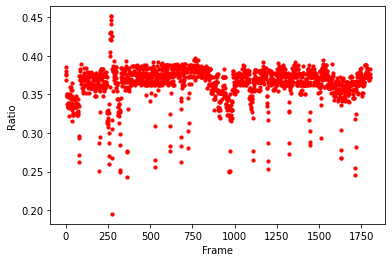

변화량 , 속도


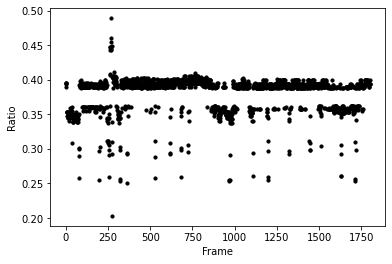

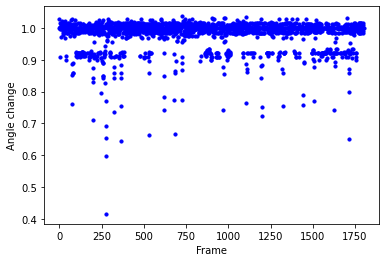

In [19]:
from matplotlib import pyplot as plt

# basic1 = np.array(basic1).T # 각도x 평균
# eye_ratio1 = np.array(eye_ratio1).T # 각도x 높이합

# x_length1 = np.array(x_length1).T # 각도o 높이합
# x_length2 = np.array(x_length2).T # 각도o 높이합

# y_length1 = np.array(y_length1).T # 각도 없이 평균
# y_length2 = np.array(y_length2).T # 각도 없이 단순합

get_ratio1 = np.array(get_ratio1).T # 각도 평균
get_ratio2 = np.array(get_ratio2).T # 각도 단순합
get_ratio3 = np.array(get_ratio3).T

# print("각도x, 평균 vs 각도o, 보정높이합")
# plt.scatter(range(len(basic1_1[1,:])),basic1[0,:],s = 10,c = 'r',label = 'No_Angle')
# plt.scatter(range(len(basic1_1[1,:])),eye_ratio1[0,:],s = 10,c = 'k',label = 'Angle')
# plt.legend(loc = 'lower left')
# plt.show()

# print("가로합 vs 보정 가로합")
# plt.scatter(range(len(basic1_1[1,:])),x_length1[0,:],s = 10,c = 'r',label = 'No_Angle')
# plt.scatter(range(len(basic1_1[1,:])),x_length2[0,:],s = 10,c = 'k',label = 'Angle')
# plt.legend(loc = 'lower left')
# plt.show()

# print("각도x, 단순 높이합 vs 각도o, 보정 높이합")
# plt.scatter(range(len(basic1_1[1,:])),y_length1[0,:],s = 10,c = 'r')
# plt.scatter(range(len(basic1_1[1,:])),y_length2[0,:],s = 10,c = 'c')
# plt.show()


print("변화량 , 속도")
plt.scatter(range(len(get_ratio1[1,:])),get_ratio1[0,:],s = 10,c = 'r')
plt.xlabel('Frame')
plt.ylabel('Ratio')
# plt.ylim(-0.05,0.05)
plt.show()
print("변화량 , 속도")
plt.scatter(range(len(get_ratio2[1,:])),get_ratio2[0,:],s = 10,c = 'k')
plt.xlabel('Frame')
plt.ylabel('Ratio')
# plt.ylim(-0.2,0.2)
plt.show()


# plt.scatter(range(len(get_ratio2[1,:])),get_ratio2[0,:],s = 10,c = 'c')
# plt.xlabel('frame')
# plt.ylabel('ratio change')
# plt.show()

plt.scatter(range(len(get_ratio3[1,:])),get_ratio3[0,:],s = 10,c = 'b')
plt.xlabel('Frame')
plt.ylabel('Angle change')
plt.show()
# 

<class 'numpy.ndarray'>


c:\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

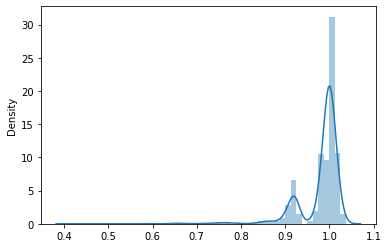

In [20]:
import seaborn as sns
a = get_ratio3[0,:]
print(type(a))
sns.distplot(a)

In [14]:
# 2 : 얼굴 각도를 고려한 눈 크기 측정(가로 길이를 평균내서 나누기)

import cv2 as cv
import numpy as np
import mediapipe as mp
import os
from matplotlib import pyplot as plt
import math
import time

FOR_3D = [386, 374,263, 362,159, 145,133, 33]
FACE=list(range(468))

LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT = [386, 374,263, 362]
RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT = [159, 145,133, 33]


LEFT_EYE_TOP_BOTTOM = [386, 374]
LEFT_EYE_LEFT_RIGHT = [263, 362]

RIGHT_EYE_TOP_BOTTOM = [159, 145]
RIGHT_EYE_LEFT_RIGHT = [133, 33]

def draw_landmark(height, width, outputs, land_mark, color):
    for face in land_mark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        point_scale = ((int)(point.x * width), (int)(point.y * height))
        cv.circle(image, point_scale, 2, color, 1)
        
def cal_distance(height, width, camera_point1, camera_point2):
    point1 = int(camera_point1.x * width), int(camera_point1.y * height)
    point2 = int(camera_point2.x * width), int(camera_point2.y * height)
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
    return distance

def get_aspect_ratio(height, width, outputs, top_bottom, left_right, secant):
    landmark = outputs.multi_face_landmarks[0]
            
    top = landmark.landmark[top_bottom[0]]
    bottom = landmark.landmark[top_bottom[1]]
    top_bottom_dis = cal_distance(height, width, top, bottom) * secant
    
    left = landmark.landmark[left_right[0]]
    right = landmark.landmark[left_right[1]]
    left_right_dis = cal_distance(height, width, left, right)
    
    aspect_ratio = top_bottom_dis / left_right_dis
    return aspect_ratio

def cal_ratio(height,width, outputs, left, right, secant):
    landmark = outputs.multi_face_landmarks[0]
    top1 = landmark.landmark[left[0]]
    bottom1 = landmark.landmark[left[1]]
    top_bottom_dis1 = cal_distance(height,width, top1, bottom1)

    top2 = landmark.landmark[right[0]]
    bottom2 = landmark.landmark[right[1]]
    top_bottom_dis2 = cal_distance(height,width, top2, bottom2)

    lwide1 = landmark.landmark[left[2]]
    rwide1 = landmark.landmark[left[3]]
    lwide_rwide_dis1 = cal_distance(height,width,lwide1, rwide1)

    lwide2 = landmark.landmark[right[2]]
    rwide2 = landmark.landmark[right[3]]
    lwide_rwide_dis2 = cal_distance(height,width,lwide2, rwide2)

    sum_wide = 0
    sum_height = 0

    if lwide_rwide_dis1!=0 and lwide_rwide_dis2 != 0: # 가로 길이 보정
        if lwide_rwide_dis1/lwide_rwide_dis2 > 1.1 or lwide_rwide_dis1 /lwide_rwide_dis2 < 0.9:
            if lwide_rwide_dis1 > lwide_rwide_dis2:
                sum_wide = round(lwide_rwide_dis1/2)*2
            else:
                sum_wide = round(lwide_rwide_dis2/2)*2
        else:
            sum_wide = (round(lwide_rwide_dis1/3)*3+round(lwide_rwide_dis2/3)*3)/2
    
    if top_bottom_dis1 !=0 and top_bottom_dis2 != 0: # 세로 길이 보정
        if top_bottom_dis1/top_bottom_dis2 > 1.1 or top_bottom_dis1/top_bottom_dis2 < 0.9:
            if top_bottom_dis1 > top_bottom_dis2:
                sum_height = round(top_bottom_dis1/2)*2
            else:
                sum_height = round(top_bottom_dis2/2)*2
        else:
            sum_height =(round(top_bottom_dis1/2)*2+round(top_bottom_dis2/2)*2)/2
    
    secant_u = math.ceil(secant*100)/100
    secant_d = math.floor(secant*100)/100
    aspect_ratio = round((round((sum_height*secant_u*secant_u*secant_u)/(sum_wide*secant_d*secant_d)/2, 3)
                        * 2 + round((sum_height*secant_u*secant_u*secant_u)/(sum_wide*secant_d*secant_d)/5, 2)*5) /2, 4)

    # aspect_ratio = round(sum_height/sum_wide/2*secant,2)*2
    
    cv.putText(image, "ratio: " + str(aspect_ratio), (100, 90), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    return aspect_ratio

def get_3D(height, width, outputs, landmark):
    face_3d = []
    face_2d = []

    for face in landmark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        x, y = int(point.x * width), int(point.y * height)
        face_2d.append([x, y])
        face_3d.append([x, y, point.z])       

    face_2d = np.array(face_2d, dtype=np.float64)
    face_3d = np.array(face_3d, dtype=np.float64)
    focal_length = width
    cam_matrix = np.array([ [focal_length, 0, height / 2],
                            [0, focal_length, width / 2],
                            [0, 0, 1]])
    dist_matrix = np.zeros((4, 1), dtype=np.float64)
    success, rot_vec, trans_vec = cv.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)
  
    rmat, jac = cv.Rodrigues(rot_vec)
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv.RQDecomp3x3(rmat)
    
    x = angles[0] * 360 * math.pi * 0.75+7

    x = np.round(x,1)
    if x > 40 :
        x = 40
    elif x <-40:
        x = -40  
    cv.putText(image, "x: " + str(x), (100, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    return x
##    
face_mesh = mp.solutions.face_mesh
draw_utils = mp.solutions.drawing_utils
face_model = face_mesh.FaceMesh(max_num_faces= 1,
                                refine_landmarks=True,
                                min_detection_confidence=0.5,
                                min_tracking_confidence=0.5)
##
DATA_PATH = os.path.join('D:\\abc','MP_Data_2_Test') 
actions = np.array(['normal','drowsy'])

# 폴더 만들기
for action in actions: 
    try: 
        os.makedirs(os.path.join(DATA_PATH, action))
    except:
        pass
    
for jj in range(1,3):
    for i in range(31,34):
        a =str(i)+"_"+str(jj)+".mp4"
        ## 영상 입력
        name = a
        cap = cv.VideoCapture(name)

        ## 영상 이름 인식
        if(name[1]!='_'):
            im = name[0]+name[1]
            print(im)    
            sequence = int(im) # '1_2.mp4' 에서 '1' -> 비디오 순서
            if int(name[3]) - 1 == 0:
                action = actions[0] # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
            else:
                action = actions[1]
        else:
            sequence = int(name[0]) # '1_2.mp4' 에서 '1' -> 비디오 순서
            if int(name[2]) - 1 == 0:
                action = actions[0] # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
            else:
                action = actions[1]
                
        ##
        ratio_mean= []
        while cap.isOpened():
            result, image = cap.read()
            if not result:
                print("Ignoring empty camera frame.")
                break
            else:
                height, width =image.shape[:2]
                image.flags.writeable = False
                image = cv.cvtColor(cv.flip(image, 1), cv.COLOR_BGR2RGB)
                outputs = face_model.process(image)
                image.flags.writeable = True
                image = cv.cvtColor(image, cv.COLOR_RGB2BGR)

                if outputs.multi_face_landmarks:
                    ##
                    draw_landmark(height, width,outputs, FOR_3D, (0,255,0))
                    draw_landmark(height, width,outputs, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))
                    draw_landmark(height, width,outputs, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))
        
                    # secant 계산
                    get_face_angle = get_3D(height, width,outputs,FACE)
                    th1 = math.radians(get_face_angle)
                    secant1 = 1.0/math.cos(th1)

                    # 각도 x
                    # secant1 = 1

                    # # 각각 ratio 구해서 평균
                    # ratio_left =  get_aspect_ratio(height, width, outputs, LEFT_EYE_TOP_BOTTOM, LEFT_EYE_LEFT_RIGHT,secant1)
                    # ratio_right =  get_aspect_ratio(height, width, outputs, RIGHT_EYE_TOP_BOTTOM, RIGHT_EYE_LEFT_RIGHT,secant1)
                    # ratio = (ratio_left + ratio_right)/2.0

                    # 각각 가로 길이 구해서 평균
                    ratio =  cal_ratio(height, width,outputs, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT,secant1)
                    if ratio > 0.12:
                        ratio_mean.append(ratio)

                cv.imshow("FACE MESH", image)
                key = cv.waitKey(2)

                if key==ord('q') or key ==ord('Q'):
                    break

        cap.release()
        cv.destroyAllWindows()
        mean_ratio = sum(ratio_mean)/len(ratio_mean)
        print("평균 EAR",mean_ratio)

        # 데이터 저장
        npy_path = os.path.join(DATA_PATH, action, str(sequence))
        np.save(npy_path, mean_ratio)

31
Ignoring empty camera frame.
평균 EAR 0.33357262569832596
32
Ignoring empty camera frame.
평균 EAR 0.342034787410271
33
Ignoring empty camera frame.
평균 EAR 0.3092199067726899
31
Ignoring empty camera frame.
평균 EAR 0.33016431924882494
32
Ignoring empty camera frame.
평균 EAR 0.27704398663697105
33
Ignoring empty camera frame.
평균 EAR 0.20800659793814139


In [48]:
# 2 : 얼굴 각도를 고려한 눈 크기 측정( ratio를 각각 구하고 평균내기 )

import cv2 as cv
import numpy as np
import mediapipe as mp
import os
from matplotlib import pyplot as plt
import math
import time

FOR_3D = [33 ,263, 6, 61, 291, 199]
FACE=list(range(468))

LEFT_EYE_TOP_BOTTOM = [386, 374]
LEFT_EYE_LEFT_RIGHT = [263, 362]

RIGHT_EYE_TOP_BOTTOM = [159, 145]
RIGHT_EYE_LEFT_RIGHT = [133, 33]

def draw_landmark(height, width, outputs, land_mark, color):
    for face in land_mark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        point_scale = ((int)(point.x * width), (int)(point.y * height))
        cv.circle(image, point_scale, 2, color, 1)
        
def cal_distance(height, width, camera_point1, camera_point2):
    point1 = int(camera_point1.x * width), int(camera_point1.y * height)
    point2 = int(camera_point2.x * width), int(camera_point2.y * height)
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
    return distance

def cal_ratio(height,width, outputs, top_bottom, left_right, secant):
    landmark = outputs.multi_face_landmarks[0]
    top = landmark.landmark[top_bottom[0]]
    bottom = landmark.landmark[top_bottom[1]]
    top_bottom_dis = cal_distance(height,width, top, bottom)
    top_bottom_dis = top_bottom_dis * secant
    left = landmark.landmark[left_right[0]]
    right = landmark.landmark[left_right[1]]
    left_right_dis = cal_distance(height,width,left, right)
    aspect_ratio = top_bottom_dis / left_right_dis
    return aspect_ratio

def get_3D(height, width, outputs, landmark):
    face_3d = []
    face_2d = []

    for face in landmark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        x, y = int(point.x * width), int(point.y * height)
        face_2d.append([x, y])
        face_3d.append([x, y, point.z])       

    face_2d = np.array(face_2d, dtype=np.float64)
    face_3d = np.array(face_3d, dtype=np.float64)
    focal_length = width
    cam_matrix = np.array([ [focal_length, 0, height / 2],
                            [0, focal_length, width / 2],
                            [0, 0, 1]])
    dist_matrix = np.zeros((4, 1), dtype=np.float64)
    success, rot_vec, trans_vec = cv.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)
  
    rmat, jac = cv.Rodrigues(rot_vec)
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv.RQDecomp3x3(rmat)
    
    x = angles[0] * 360 * math.pi * 0.67
    str_x = str(np.round(x,2))
    cv.putText(image, "x: " + str_x, (100, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    return x
##    
face_mesh = mp.solutions.face_mesh
draw_utils = mp.solutions.drawing_utils
face_model = face_mesh.FaceMesh(max_num_faces= 1,
                                refine_landmarks=True,
                                min_detection_confidence=0.5,
                                min_tracking_confidence=0.5)
##
DATA_PATH = os.path.join('D:\\abc','MP_Data_Test') 
actions = np.array(['normal','drowsy'])

# 폴더 만들기
for action in actions: 
    try: 
        os.makedirs(os.path.join(DATA_PATH, action))
    except:
        pass
for jj in range(1,3):
    for i in range(30,34):
        a =str(i)+"_"+str(jj)+".mp4"
        ## 영상 입력
        name = a
        cap = cv.VideoCapture(name)

        ## 영상 이름 인식
        if(name[1]!='_'):
            im = name[0]+name[1]
            print(im)    
            sequence = int(im) # '1_2.mp4' 에서 '1' -> 비디오 순서
            if int(name[3]) - 1 == 0:
                action = actions[0] # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
            else:
                action = actions[1]
        else:
            sequence = int(name[0]) # '1_2.mp4' 에서 '1' -> 비디오 순서
            if int(name[2]) - 1 == 0:
                action = actions[0] # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
            else:
                action = actions[1]
                
        ##
        time_check = []
        face_updown_angle = []
        secant = 0
        ratio_mean= []
        fps2 = cap.get(cv.CAP_PROP_FPS)
        prev_time = 0

        width=cap.get(cv.CAP_PROP_FRAME_WIDTH)
        height=cap.get(cv.CAP_PROP_FRAME_HEIGHT)

        while cap.isOpened():
            # 프레임 당 처리 속도를 영상 속도에 맞춤
            # current_time = time.time() - prev_time
            # if (current_time >= ((1./fps2)-0.001)):
            #     prev_time = time.time()
            result, image = cap.read()

            if not result:
                print("Ignoring empty camera frame.")
                break
            else:
                height, width =image.shape[:2]
                image.flags.writeable = False
                image = cv.cvtColor(cv.flip(image, 1), cv.COLOR_BGR2RGB)
                outputs = face_model.process(image)

                image.flags.writeable = True
                image = cv.cvtColor(image, cv.COLOR_RGB2BGR)

                if outputs.multi_face_landmarks:
                    ##
                    draw_landmark(height, width,outputs, FOR_3D, (0,255,0))
                    draw_landmark(height, width,outputs, LEFT_EYE_TOP_BOTTOM, (0,0,255))
                    draw_landmark(height, width,outputs, LEFT_EYE_LEFT_RIGHT, (0,0,255)) 
                    draw_landmark(height, width,outputs, RIGHT_EYE_TOP_BOTTOM, (0,0,255))
                    draw_landmark(height, width,outputs, RIGHT_EYE_LEFT_RIGHT, (0,0,255))

                    # # secant 계산
                    # get_face_angle = get_3D(height, width,outputs,FACE)
                    # th = math.radians(get_face_angle)
                    # secant = 1.0/math.cos(th)

                    # secant 계산 x
                    secant = 1

                    ratio_left =  cal_ratio(height, width,outputs, LEFT_EYE_TOP_BOTTOM, LEFT_EYE_LEFT_RIGHT,secant)
                    ratio_right =  cal_ratio(height, width,outputs, RIGHT_EYE_TOP_BOTTOM, RIGHT_EYE_LEFT_RIGHT,secant)
                    ratio = (ratio_left + ratio_right)/2.0
                    
                    if ratio > 0.14:
                        ratio_mean.append(ratio)

                cv.imshow("FACE MESH", image)
                key = cv.waitKey(2)

                if key==ord('q') or key ==ord('Q'):
                    break

        cap.release()
        cv.destroyAllWindows()

        mean_ratio = sum(ratio_mean)/len(ratio_mean)
        print("평균 EAR",mean_ratio)

        # 데이터 저장
        npy_path = os.path.join(DATA_PATH, action, str(sequence))
        np.save(npy_path, mean_ratio)

평균 EAR 0.3085817352964857
평균 EAR 0.35160343137716965


KeyboardInterrupt: 

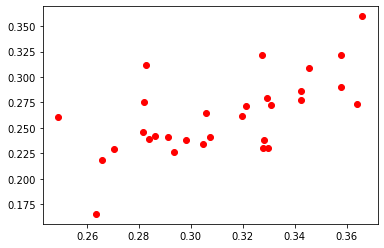

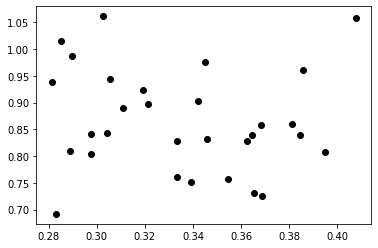

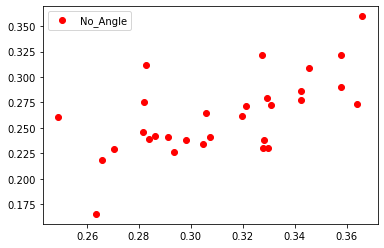

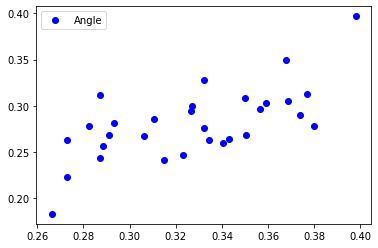

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split

DATA_PATH = os.path.join('D:\\abc','MP_Data_2_no_angle_noblink') 
DATA_PATH_2 = os.path.join('D:\\abc','MP_Data_2_different_noblink_6')
DATA_PATH_3 = os.path.join('D:\\abc','MP_Data_2_no_angle_noblink') 
DATA_PATH_4 = os.path.join('D:\\abc','MP_Data_2_different_noblink_3') 
actions = np.array(['normal','drowsy'])
no_sequences = 30
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], [] 

arr =  [[0 for j in range(no_sequences)] for i in range(len(actions))]
arr_2 =  [[0 for j in range(no_sequences)] for i in range(len(actions))]
arr_3 =  [[0 for j in range(no_sequences)] for i in range(len(actions))]
arr_4 =  [[0 for j in range(no_sequences)] for i in range(len(actions))]
for idx, lm in enumerate(actions):
    for sequence in range(no_sequences) :  # 5번 반복(영상 수)
        res = np.load(os.path.join(DATA_PATH, lm, "{}.npy".format(str(sequence+1))))
        res_2 = np.load(os.path.join(DATA_PATH_2, lm, "{}.npy".format(str(sequence+1))))
        res_3 = np.load(os.path.join(DATA_PATH_3, lm, "{}.npy".format(str(sequence+1))))
        res_4 = np.load(os.path.join(DATA_PATH_4, lm, "{}.npy".format(str(sequence+1))))
        arr[idx][sequence] = res
        arr_2[idx][sequence] = res_2
        arr_3[idx][sequence] = res_3
        arr_4[idx][sequence] = res_4
        # sequences.append(res) # sequence = 5개 영상에 들어있는 모든 프레임 데이터
        # labels.append(label_map[lm]) # 2개의 폴더(분류 개수), 각 폴더마다 5개의 영상을 표시 000001111

arr = np.array(arr)
arr_2 = np.array(arr_2)
arr_3 = np.array(arr_3)
arr_4 = np.array(arr_4)
# plt.plot(range(len(arr[0,:])),range(len(arr[0,:])))
plt.plot(arr[0,:], arr[1,:],'ro')

# plt.xlim([0.225,0.4])
# plt.ylim([0.1,0.4])
plt.show()
plt.plot(arr_2[0,:], arr_2[1,:]/arr_2[0,:] ,'ko')
# plt.plot(arr_2[0,:]*10, (arr_2[1,:]*10)**2,'yo')
# plt.legend(loc = 'upper left')
# plt.xlim([0.225,0.5])
# plt.ylim([0.1,0.5])
plt.show()

# plt.plot(arr_2[0,:], arr_2[1,:],'go')
# plt.show()

plt.plot(arr_3[0,:], arr_3[1,:],'ro',label = 'No_Angle')
plt.legend(loc = 'upper left')
# plt.xlim([0.225,0.4])
# plt.ylim([0.1,0.4])
plt.show()
plt.plot(arr_4[0,:], arr_4[1,:],'bo',label = 'Angle')
plt.legend(loc = 'upper left')
# plt.xlim([0.225,0.4])
# plt.ylim([0.1,0.4])

plt.show()





Epoch 1/5500
30/30 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010    
Epoch 2/5500
30/30 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010
Epoch 3/5500
30/30 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010   
Epoch 4/5500
30/30 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010
Epoch 5/5500
30/30 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010
Epoch 6/5500
30/30 [==============================] - 0s 1ms/step - loss: 0.0010 - mse: 0.0010
Epoch 7/5500
30/30 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010   
Epoch 8/5500
30/30 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010
Epoch 9/5500
30/30 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010    
Epoch 10/5500
30/30 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010    
Epoch 11/5500
30/30 [==========

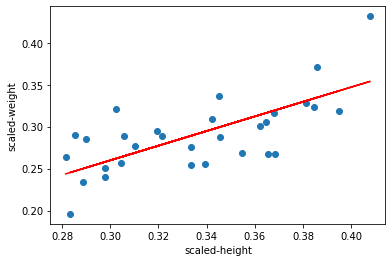

In [12]:
# 단순 선형 회귀 예제 (케라스)
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import optimizers
# 훈련용 데이터
x_train = arr_2[0,:] # 입력
y_train = arr_2[1,:] # 결
# 모델 생성
model = Sequential()
# 입력 값은 1차원 자료: input_dim=1
model.add(Dense(1,kernel_initializer='he_normal', input_dim=1,activation='linear'))
# 최적화 방식
adam = optimizers.Adam(lr=0.0000002)
# cost/loss 함수로 컴파일 작업
model.compile(loss='mean_squared_error', optimizer=adam,metrics=['mse'])
# 훈련
h = model.fit(x_train, y_train,batch_size=1, epochs=5500)  # 100번 반복 훈련

from sklearn import preprocessing

mm_scaler = preprocessing.MinMaxScaler()
# X_train = mm_scaler.fit_transform(x_train)
# Y_train = mm_scaler.transform(y)
w, b = model.get_weights()
w =  w[0][0]
b = b[0]
# x_scale = mm_scaler.transform(x_train)
# y_scale = mm_scaler.transform(y_train)
plt.scatter(x_train, y_train)
plt.plot(x_train, w*x_train+b, 'r')
plt.xlabel('scaled-height')
plt.ylabel('scaled-weight')
print(w,b)
plt.show()

In [50]:
# 3 : EAR 데이터 프레임별 추출(LSTM 데이터 추출용)
import cv2 as cv
import numpy as np
import mediapipe as mp
import os
from matplotlib import pyplot as plt
import math
import time

FOR_3D = [33 ,263, 6, 61, 291, 199]
FACE=list(range(468))

LEFT_EYE_TOP_BOTTOM = [386, 374]
LEFT_EYE_LEFT_RIGHT = [263, 362]

RIGHT_EYE_TOP_BOTTOM = [159, 145]
RIGHT_EYE_LEFT_RIGHT = [133, 33]

def draw_landmark(height, width, outputs, land_mark, color):
    for face in land_mark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        point_scale = ((int)(point.x * width), (int)(point.y * height))
        cv.circle(image, point_scale, 2, color, 1)
        
def cal_distance(height, width, camera_point1, camera_point2):
    point1 = int(camera_point1.x * width), int(camera_point1.y * height)
    point2 = int(camera_point2.x * width), int(camera_point2.y * height)
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
    return distance

def cal_ratio(height,width, outputs, top_bottom, left_right, secant):
    landmark = outputs.multi_face_landmarks[0]
    top = landmark.landmark[top_bottom[0]]
    bottom = landmark.landmark[top_bottom[1]]
    top_bottom_dis = cal_distance(height,width, top, bottom)
    top_bottom_dis = top_bottom_dis * secant
    left = landmark.landmark[left_right[0]]
    right = landmark.landmark[left_right[1]]
    left_right_dis = cal_distance(height,width,left, right)
    aspect_ratio = top_bottom_dis / left_right_dis
    return aspect_ratio

def get_3D(height, width, outputs, landmark):
    face_3d = []
    face_2d = []

    for face in landmark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        x, y = int(point.x * width), int(point.y * height)
        face_2d.append([x, y])
        face_3d.append([x, y, point.z])       

    face_2d = np.array(face_2d, dtype=np.float64)
    face_3d = np.array(face_3d, dtype=np.float64)
    focal_length = width
    cam_matrix = np.array([ [focal_length, 0, height / 2],
                            [0, focal_length, width / 2],
                            [0, 0, 1]])
    dist_matrix = np.zeros((4, 1), dtype=np.float64)
    success, rot_vec, trans_vec = cv.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)
  
    rmat, jac = cv.Rodrigues(rot_vec)
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv.RQDecomp3x3(rmat)
    
    x = angles[0] * 360 * math.pi * 0.67
    str_x = str(np.round(x,2))
    cv.putText(image, "x: " + str_x, (100, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    return x

##    
face_mesh = mp.solutions.face_mesh
draw_utils = mp.solutions.drawing_utils
face_model = face_mesh.FaceMesh(max_num_faces= 1,
                                refine_landmarks=True,
                                min_detection_confidence=0.5,
                                min_tracking_confidence=0.5)
##
DATA_PATH = os.path.join('D:\\abc','MP_Data_5(450,tan(past.r-present.r))') 
actions = np.array(['normal','drowsy'])
# 영상 갯수
no_sequences = 30

# 폴더 만들기
for action in actions: 
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

for i in range(1,31):
    # 한 영상당 프레임 수
    sequence_length = 450

    a = str(i)+"_2.mp4"
    ## 영상 입력
    name = a
    
    idx = 0
    ## 영상 이름 인식
    if(name[1] != '_'):
        im = name[0]+name[1]
        print(im)
        sequence = int(im)  # '1_2.mp4' 에서 '1' -> 비디오 순서
        if int(name[3]) - 1 == 0:
            idx = 0
            action = actions[0]  # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
        else:
            idx = 1
            action = actions[1]
    else:
        sequence = int(name[0])  # '1_2.mp4' 에서 '1' -> 비디오 순서
        if int(name[2]) - 1 == 0:
            idx = 0
            action = actions[0]  # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
        else:
            idx = 1
            action = actions[1]

    ##
    time_check = []
    face_updown_angle = []
    secant = 0
    ratio_mean = []
    prev_time = 0
    sequence_loop = 0
    padding = False
    cutting = False

    cap = cv.VideoCapture(name)
    video_fps = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

    # 비디오 프레임수랑 설정한 sequence_lenght랑 맞지 않을 경우
    if(video_fps < sequence_length): # 비디오 프레임이 부족할 경우, 첫 이미지에서 추출한 데이터를 복사해 설정한 프레임 수에 맞춘다.
        padding = True
        difference = sequence_length - video_fps 
        sequence_loop = video_fps
        print("padding!",difference)
    else: # 비디오 프레임이 많을 경우, 설정한 프레임 수를 비디오 프레임 수에 맞추고 앞 부분 프레임은 저장하지 않고, 뒷 부분만 저장한다.
        cutting = True
        difference = video_fps - sequence_length
        sequence_loop = video_fps
        print("cutting!",difference)
    
    ratio_variance = []
    get_face_angle_variance = []

    for frame_num in range(sequence_loop):
        result, image = cap.read()
        if not result:
            print(i,"번 영상 문제 있음")
            pass
        else:
            image = cv.cvtColor(cv.flip(image, 1), cv.COLOR_BGR2RGB)
            image.flags.writeable = False
            outputs = face_model.process(image)
            image.flags.writeable = True
            image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
            height, width = image.shape[:2]
            sub_ratio = 0
            if outputs.multi_face_landmarks:
                draw_landmark(height, width, outputs, FOR_3D, (0, 255, 0))
                draw_landmark(height, width, outputs, LEFT_EYE_TOP_BOTTOM, (0, 0, 255))
                draw_landmark(height, width, outputs, LEFT_EYE_LEFT_RIGHT, (0, 0, 255))
                draw_landmark(height, width, outputs, RIGHT_EYE_TOP_BOTTOM, (0, 0, 255))
                draw_landmark(height, width, outputs, RIGHT_EYE_LEFT_RIGHT, (0, 0, 255))

                # secant 계산
                get_face_angle = get_3D(height, width, outputs, FACE)
                th = math.radians(get_face_angle)
                secant = 1.0/math.cos(th)

                # 비율 계산
                ratio_left = cal_ratio(height, width, outputs, LEFT_EYE_TOP_BOTTOM, LEFT_EYE_LEFT_RIGHT, secant)
                ratio_right = cal_ratio(height, width, outputs, RIGHT_EYE_TOP_BOTTOM, RIGHT_EYE_LEFT_RIGHT, secant)
                ratio = (ratio_left + ratio_right)/2.0

                # 데이터 : 한 프레임 전 ratio에 대한 변화량, 현재 ratio 
                if frame_num >= (difference-1):
                    ratio_variance.append(ratio)
                    get_face_angle_variance.append(get_face_angle)
                if len(ratio_variance) > 1:
                    ratio_variance_change = ratio_variance[-1]- ratio_variance[-2]
                    # 변화율을 표준화 시키기 위함
                    ratio_variance_change_velocity = ratio_variance_change / ratio_variance[-2]
                    # 얼굴 각도 데이터도 학습하기 위함
                    get_face_angle_variance_change = get_face_angle_variance[-1] - get_face_angle_variance[-2]
                    # 값이 너무 작으므로 차이를 극대화 시키기 위함
                    mul = math.tan(3*ratio_variance_change_velocity)
                    input_data = np.array([mul,get_face_angle_variance_change,ratio*10])
                    # 인식 실패시 사용할 임시 ratio
                    sub_ratio = input_data

                cv.putText(image, "total_frame"+str(video_fps), (100, 100), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv.putText(image, "frame_num"+str(frame_num), (100, 150), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                if(padding):
                    if(frame_num == 1):
                        for i in range(difference):
                            npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num+i))
                            cv.putText(image, "save_idx:"+str(frame_num+i), (100, 200), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                            np.save(npy_path, input_data)
                    elif frame_num > 1:
                        npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num+difference-1))
                        cv.putText(image, "save_idx"+str(frame_num+difference-1), (100, 200), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                        np.save(npy_path, input_data)
                        
                
                if(cutting and frame_num >= difference):
                    cv.putText(image, "difference"+str(frame_num - difference), (100, 200), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num - difference))
                    np.save(npy_path, input_data)

            else :
                print("인식 실패")
                # 얼굴 인식 실패했기 때문에 데이터 개수를 맞추기 위해 이전 데이터를 복사해서 저장한다.
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num-difference))
                np.save(npy_path, sub_ratio)

            cv.imshow("FACE MESH", image)
            key = cv.waitKey(2)

            if key == ord('q') or key == ord('Q'):
                break

    cap.release()
    cv.destroyAllWindows()


cutting! 1362
cutting! 1323
인식 실패
cutting! 1333
인식 실패
cutting! 1366
인식 실패
cutting! 1049
인식 실패
cutting! 1348
인식 실패
cutting! 1348
인식 실패
cutting! 1350
cutting! 1348
인식 실패
10
cutting! 1350
인식 실패
11
cutting! 1369
12
cutting! 1350
인식 실패
13
cutting! 1329
인식 실패
14
cutting! 499
인식 실패
15
cutting! 1368
인식 실패
16
cutting! 1331
17
cutting! 989
18
cutting! 558
19
cutting! 1348
인식 실패
20
cutting! 260
인식 실패
인식 실패
인식 실패
21
cutting! 1374
인식 실패
22
cutting! 1309
23
cutting! 1363
24
cutting! 1319
25
cutting! 1364
26
cutting! 1364
27
cutting! 1351
28
cutting! 1377
29
cutting! 1311
30
cutting! 445


In [ ]:
# 4 : EAR 데이터 시간별 추출 EAR 변화 정도를 확인하기 위해서(EAR 변화가 언제 심한지 알기 위함)

import cv2 as cv
import numpy as np
import mediapipe as mp
import os
from matplotlib import pyplot as plt
import math
import time

FOR_3D = [33 ,263, 6, 61, 291, 199]
FACE=list(range(468))

LEFT_EYE_TOP_BOTTOM = [386, 374]
LEFT_EYE_LEFT_RIGHT = [263, 362]

RIGHT_EYE_TOP_BOTTOM = [159, 145]
RIGHT_EYE_LEFT_RIGHT = [133, 33]

def draw_landmark(height, width, outputs, land_mark, color):
    for face in land_mark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        point_scale = ((int)(point.x * width), (int)(point.y * height))
        cv.circle(image, point_scale, 2, color, 1)
        
def cal_distance(height, width, camera_point1, camera_point2):
    point1 = int(camera_point1.x * width), int(camera_point1.y * height)
    point2 = int(camera_point2.x * width), int(camera_point2.y * height)
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
    return distance

def cal_ratio(height,width, outputs, top_bottom, left_right, secant):
    landmark = outputs.multi_face_landmarks[0]
    top = landmark.landmark[top_bottom[0]]
    bottom = landmark.landmark[top_bottom[1]]
    top_bottom_dis = cal_distance(height,width, top, bottom)
    top_bottom_dis = top_bottom_dis * secant
    left = landmark.landmark[left_right[0]]
    right = landmark.landmark[left_right[1]]
    left_right_dis = cal_distance(height,width,left, right)
    aspect_ratio = top_bottom_dis / left_right_dis
    return aspect_ratio

def get_3D(height, width, outputs, landmark):
    face_3d = []
    face_2d = []

    for face in landmark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        x, y = int(point.x * width), int(point.y * height)
        face_2d.append([x, y])
        face_3d.append([x, y, point.z])       

    face_2d = np.array(face_2d, dtype=np.float64)
    face_3d = np.array(face_3d, dtype=np.float64)
    focal_length = width
    cam_matrix = np.array([ [focal_length, 0, height / 2],
                            [0, focal_length, width / 2],
                            [0, 0, 1]])
    dist_matrix = np.zeros((4, 1), dtype=np.float64)
    success, rot_vec, trans_vec = cv.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)
  
    rmat, jac = cv.Rodrigues(rot_vec)
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv.RQDecomp3x3(rmat)
    
    x = angles[0] * 360 * math.pi * 0.67
    str_x = str(np.round(x,2))
    cv.putText(image, "x: " + str_x, (100, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    return x
##    
face_mesh = mp.solutions.face_mesh
draw_utils = mp.solutions.drawing_utils
face_model = face_mesh.FaceMesh(max_num_faces= 1,
                                refine_landmarks=True,
                                min_detection_confidence=0.5,
                                min_tracking_confidence=0.5)
##
DATA_PATH = os.path.join('D:\\abc','MP_Data_3') 
actions = np.array(['normal','drowsy'])

# 폴더 만들기
for action in actions: 
    try: 
        os.makedirs(os.path.join(DATA_PATH, action))
    except:
        pass

EARtime_check = np.array([])
for i in range(1,28):
    a =str(21)+"_2.mp4"
    ## 영상 입력
    name = a

    cap = cv.VideoCapture(name)

    ## 영상 이름 인식
    if(name[1]!='_'):
        im = name[0]+name[1]
        print(im)    
        sequence = int(im) # '1_2.mp4' 에서 '1' -> 비디오 순서
        if int(name[3]) - 1 == 0:
            action = actions[0] # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
        else:
            action = actions[1]
    else:
        sequence = int(name[0]) # '1_2.mp4' 에서 '1' -> 비디오 순서
        if int(name[2]) - 1 == 0:
            action = actions[0] # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
        else:
            action = actions[1]
            
    ##
    time_check = []
    face_updown_angle = []
    secant = 0
    ratio_mean= []
    fps2 = cap.get(cv.CAP_PROP_FPS)
    prev_time = 0

    while cap.isOpened():
        # 프레임 당 처리 속도를 영상 속도에 맞춤
        current_time = time.time() - prev_time
        if (current_time >= ((1./fps2)-0.001)):
            prev_time = time.time()
            result, image = cap.read()

            if not result:
                print("Ignoring empty camera frame.")
                break
            else:
                height, width =image.shape[:2]
                image.flags.writeable = False
                image = cv.cvtColor(cv.flip(image, 1), cv.COLOR_BGR2RGB)
                outputs = face_model.process(image)

                image.flags.writeable = True
                image = cv.cvtColor(image, cv.COLOR_RGB2BGR)

                if outputs.multi_face_landmarks:
                    ##
                    draw_landmark(height, width,outputs, FOR_3D, (0,255,0))
                    draw_landmark(height, width,outputs, LEFT_EYE_TOP_BOTTOM, (0,0,255))
                    draw_landmark(height, width,outputs, LEFT_EYE_LEFT_RIGHT, (0,0,255)) 
                    draw_landmark(height, width,outputs, RIGHT_EYE_TOP_BOTTOM, (0,0,255))
                    draw_landmark(height, width,outputs, RIGHT_EYE_LEFT_RIGHT, (0,0,255))

                    # secant 계산
                    get_face_angle = get_3D(height, width,outputs,FACE)
                    th = math.radians(get_face_angle)
                    secant = 1.0/math.cos(th)

                    ratio_left =  cal_ratio(height, width,outputs, LEFT_EYE_TOP_BOTTOM, LEFT_EYE_LEFT_RIGHT,secant)
                    ratio_right =  cal_ratio(height, width,outputs, RIGHT_EYE_TOP_BOTTOM, RIGHT_EYE_LEFT_RIGHT,secant)
                    ratio = (ratio_left + ratio_right)/2.
                    
                cv.imshow("FACE MESH", image)
                key = cv.waitKey(2)

                if key==ord('q') or key ==ord('Q'):
                    break

    cap.release()
    cv.destroyAllWindows()

    mean_ratio = sum(ratio_mean)/len(ratio_mean)
    print("평균 EAR",mean_ratio)